In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1) SIAC trabalhos CT


Lendo e extraindo csv

In [ ]:
arquivo_entrada = 'SIAC_trabalhos_CT.csv'
print(f"\n[1] Lendo arquivo: {arquivo_entrada}")

try:
    # Tenta ler com utf-8, se falhar tenta latin-1
    df = pd.read_csv(arquivo_entrada, encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(arquivo_entrada, encoding='latin-1')
except FileNotFoundError:
    print("ERRO: O arquivo não foi encontrado. Faça o upload no menu lateral esquerdo.")
    # Cria um dataframe vazio para evitar erro nas linhas seguintes se o arquivo não existir
    df = pd.DataFrame()

if not df.empty:
    print(f"    Registros originais carregados: {len(df)}")
    print(f"    Colunas encontradas: {list(df.columns)}")


[1] Lendo arquivo: SIAC_trabalhos_CT.csv
    Registros originais carregados: 654
    Colunas encontradas: ['area', 'modalidade', 'artigo', 'titulo', 'autores', 'orientadores', 'resumo', 'bibliografia']


## Tratamento e Transformação dos dados

In [ ]:
print("\n[2] Iniciando Tratamento e Limpeza...")

# 2.1 Deduplicação
linhas_iniciais = len(df)
df.drop_duplicates(subset=['artigo'], keep='first', inplace=True)
linhas_finais = len(df)
print(f"    Registros duplicados removidos: {linhas_iniciais - linhas_finais}")

# 2.2 Tratamento de Valores Ausentes (Null/NaN)
colunas_texto = ['titulo', 'autores', 'orientadores', 'resumo', 'bibliografia']
for col in colunas_texto:
    if col in df.columns:
        nulos = df[col].isnull().sum()
        if nulos > 0:
            print(f"    Preenchendo {nulos} valores vazios na coluna '{col}'")
            df[col] = df[col].fillna("Não Informado")

# 2.3 Padronização de Strings (Normalização)
colunas_categoricas = ['area', 'modalidade']
for col in colunas_categoricas:
    if col in df.columns:
        # Converte para string primeiro para evitar erro se houver números, depois padroniza
        df[col] = df[col].astype(str).str.strip().str.title()

# 2.4 Enriquecimento de Dados
# Contar número de caracteres no resumo
df['tamanho_resumo'] = df['resumo'].apply(lambda x: len(str(x)))

# Estimar número de orientadores
def contar_pessoas(texto):
    if str(texto) == "Não Informado" or str(texto) == "":
        return 0
    return str(texto).count(',') + 1

df['qtd_orientadores'] = df['orientadores'].apply(contar_pessoas)

# 2.5 Normalização Numérica (Min-Max)
if 'tamanho_resumo' in df.columns:
    min_val = df['tamanho_resumo'].min()
    max_val = df['tamanho_resumo'].max()
    if max_val != min_val: # Evita divisão por zero
        df['tamanho_resumo_norm'] = (df['tamanho_resumo'] - min_val) / (max_val - min_val)
    else:
        df['tamanho_resumo_norm'] = 0.0


[2] Iniciando Tratamento e Limpeza...
    Registros duplicados removidos: 0
    Preenchendo 654 valores vazios na coluna 'autores'




```
# Isto está formatado como código
```

## Análise Expoloratória (EDA)

In [ ]:
print("\n[3] Gerando Estatísticas e Gráficos...")

# 3.1 Estatísticas Descritivas (Campos Quantitativos)
stats_desc = df[['tamanho_resumo', 'qtd_orientadores']].describe()
print("\n--- Estatísticas Descritivas ---")
print(stats_desc)

# 3.2 Contagens por Agrupamento (Campos Qualitativos)
contagem_modalidade = df['modalidade'].value_counts()
contagem_area = df['area'].value_counts()


[3] Gerando Estatísticas e Gráficos...

--- Estatísticas Descritivas ---
       tamanho_resumo  qtd_orientadores
count      654.000000        654.000000
mean      2532.568807          1.495413
std        481.194004          0.786064
min        181.000000          1.000000
25%       2208.750000          1.000000
50%       2685.000000          1.000000
75%       2950.750000          2.000000
max       3146.000000          4.000000


Gerando Gráficos

/tmp/ipython-input-3324348744.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='modalidade', data=df, order=df['modalidade'].value_counts().index, palette='viridis')


    Gráfico salvo: grafico_modalidades.png


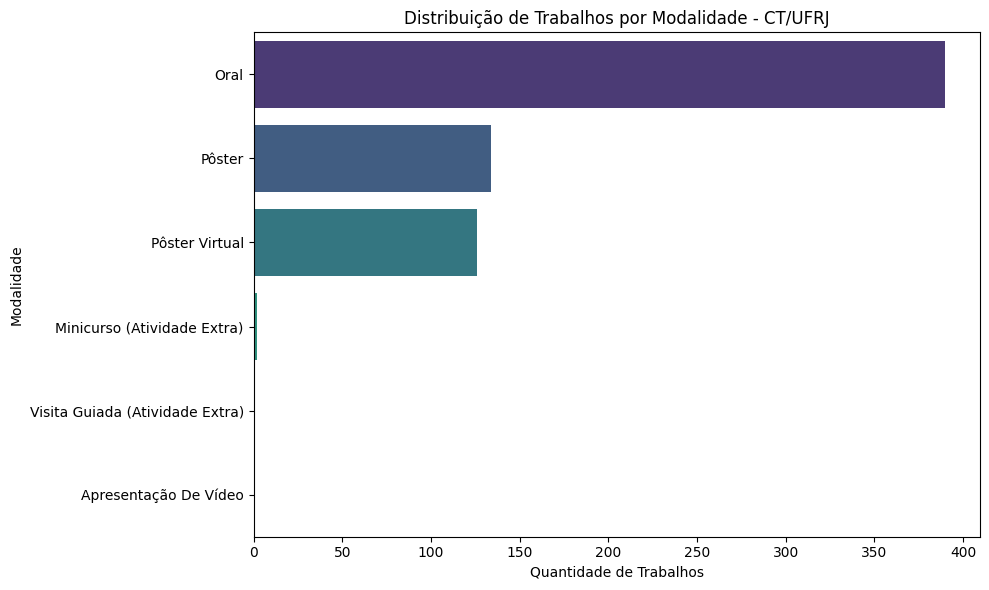

In [ ]:
# Gráfico 1: Distribuição por Modalidade
plt.figure(figsize=(10, 6))
sns.countplot(y='modalidade', data=df, order=df['modalidade'].value_counts().index, palette='viridis')
plt.title('Distribuição de Trabalhos por Modalidade - CT/UFRJ')
plt.xlabel('Quantidade de Trabalhos')
plt.ylabel('Modalidade')
plt.tight_layout()
plt.savefig('grafico_modalidades.png')
print("    Gráfico salvo: grafico_modalidades.png")

/tmp/ipython-input-489726302.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contagem_area.values, y=contagem_area.index, palette='magma')


    Gráfico salvo: grafico_areas.png


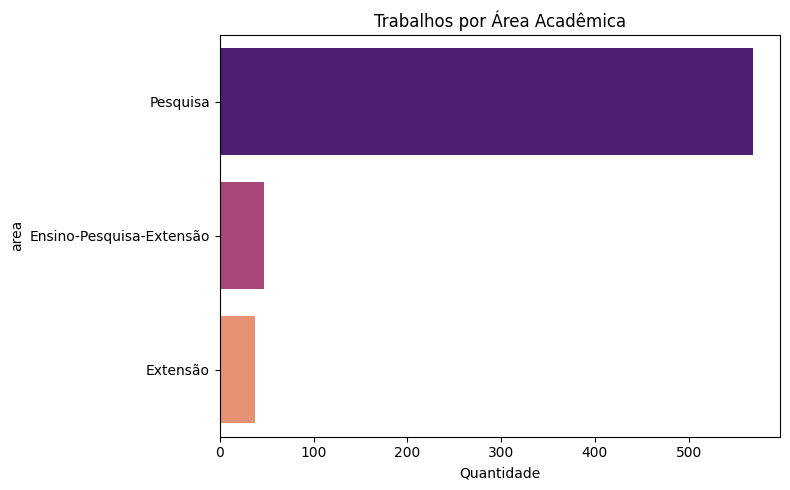

In [ ]:
# Gráfico 2: Distribuição por Área
plt.figure(figsize=(8, 5))
sns.barplot(x=contagem_area.values, y=contagem_area.index, palette='magma')
plt.title('Trabalhos por Área Acadêmica')
plt.xlabel('Quantidade')
plt.tight_layout()
plt.savefig('grafico_areas.png')
print("    Gráfico salvo: grafico_areas.png")

    Gráfico salvo: grafico_histograma_resumos.png


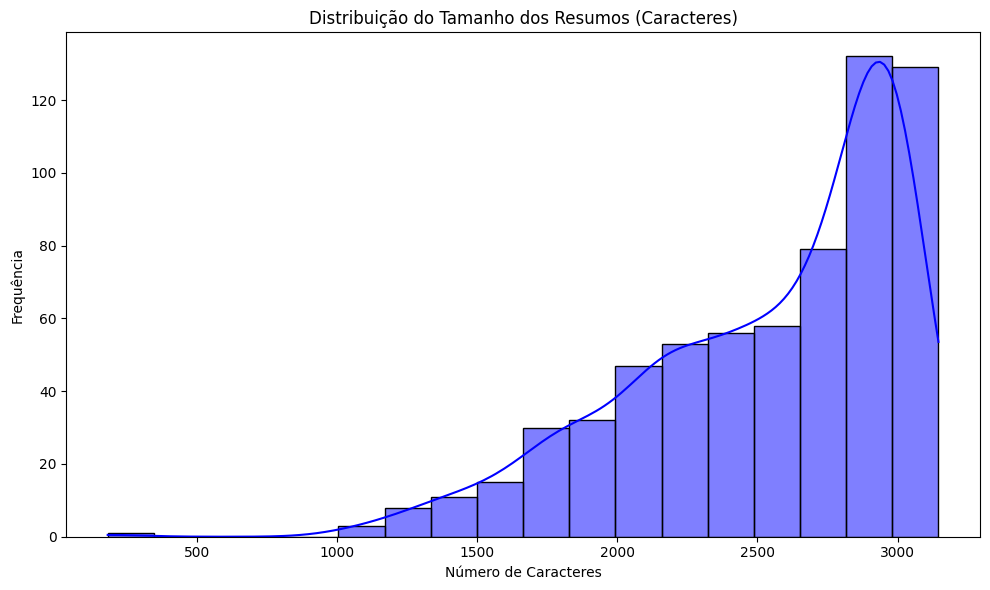

In [ ]:
# Gráfico 3: Histograma do Tamanho dos Resumos (Análise de Outliers potencial)
plt.figure(figsize=(10, 6))
sns.histplot(df['tamanho_resumo'], kde=True, color='blue')
plt.title('Distribuição do Tamanho dos Resumos (Caracteres)')
plt.xlabel('Número de Caracteres')
plt.ylabel('Frequência')
plt.tight_layout()
plt.savefig('grafico_histograma_resumos.png')
print("    Gráfico salvo: grafico_histograma_resumos.png")

In [ ]:
# 3.4 Identificação de Outliers (Exemplo: Resumos muito curtos ou muito longos)
# Considerando outlier quem está fora de 1.5 * IQR
Q1 = df['tamanho_resumo'].quantile(0.25)
Q3 = df['tamanho_resumo'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['tamanho_resumo'] < (Q1 - 1.5 * IQR)) | (df['tamanho_resumo'] > (Q3 + 1.5 * IQR))]
print(f"\n    Outliers de tamanho de resumo detectados: {len(outliers)}")


    Outliers de tamanho de resumo detectados: 2


\## Salvamento do arquivo final pós limpeza (pós EDA)

In [ ]:
print("\n[4] Salvando Base de Dados Tratada...")

# Selecionar colunas finais limpas e organizadas
colunas_finais = [
    'artigo', 'area', 'modalidade', 'titulo',
    'autores', 'qtd_orientadores', 'orientadores',
    'resumo', 'tamanho_resumo'
]

df_final = df[colunas_finais]

# Salvar em CSV (formato Tidy: cada observação numa linha)
nome_saida = 'SIAC_CT_Tratado.csv'
df_final.to_csv(nome_saida, index=False, encoding='utf-8-sig')
print(f"    Arquivo final gerado: {nome_saida}")

print("\n--- PROCESSO CONCLUÍDO COM SUCESSO ---")



[4] Salvando Base de Dados Tratada...
    Arquivo final gerado: SIAC_CT_Tratado.csv

--- PROCESSO CONCLUÍDO COM SUCESSO ---


### Extra

#### Distribuição por Área e Modalidade

In [ ]:
df_grouped_area_modalidade = df.groupby('area')['modalidade'].value_counts().reset_index(name="count")
df_grouped_area_modalidade

,area,modalidade,count
0,Ensino-Pesquisa-Extensão,Oral,32
1,Ensino-Pesquisa-Extensão,Pôster,7
2,Ensino-Pesquisa-Extensão,Pôster Virtual,5
3,Ensino-Pesquisa-Extensão,Minicurso (Atividade Extra),2
4,Ensino-Pesquisa-Extensão,Visita Guiada (Atividade Extra),1
5,Extensão,Oral,29
6,Extensão,Pôster,4
7,Extensão,Pôster Virtual,4
8,Extensão,Apresentação De Vídeo,1
9,Pesquisa,Oral,329


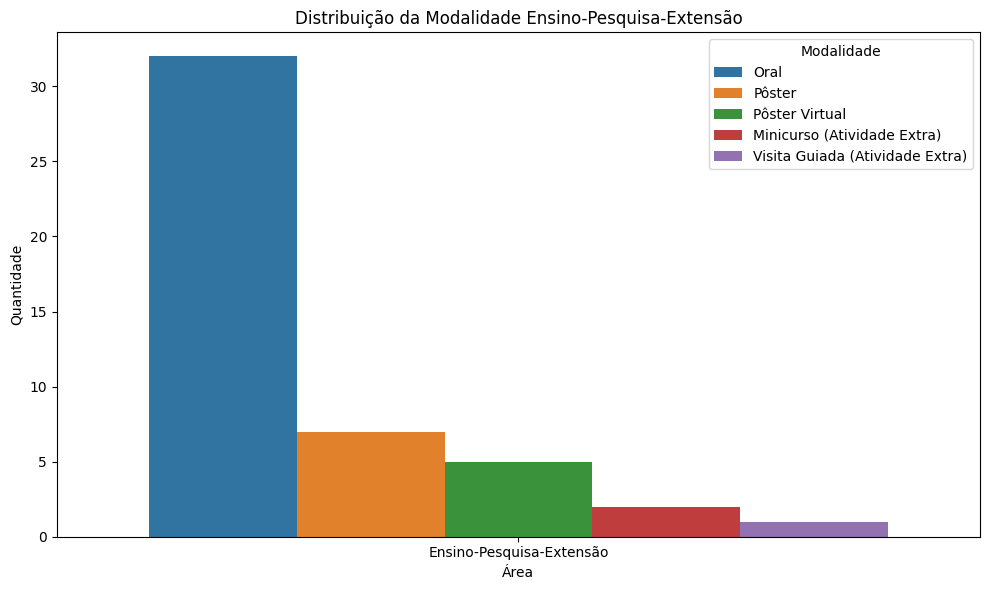

In [ ]:
df_grouped = df_grouped_area_modalidade[df_grouped_area_modalidade['area'] == 'Ensino-Pesquisa-Extensão']

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_grouped,
    x="area",
    y="count",
    hue="modalidade"
)

plt.title("Distribuição da Modalidade Ensino-Pesquisa-Extensão")
plt.xlabel("Área")
plt.ylabel("Quantidade")
plt.legend(title="Modalidade")
plt.tight_layout()
plt.show()

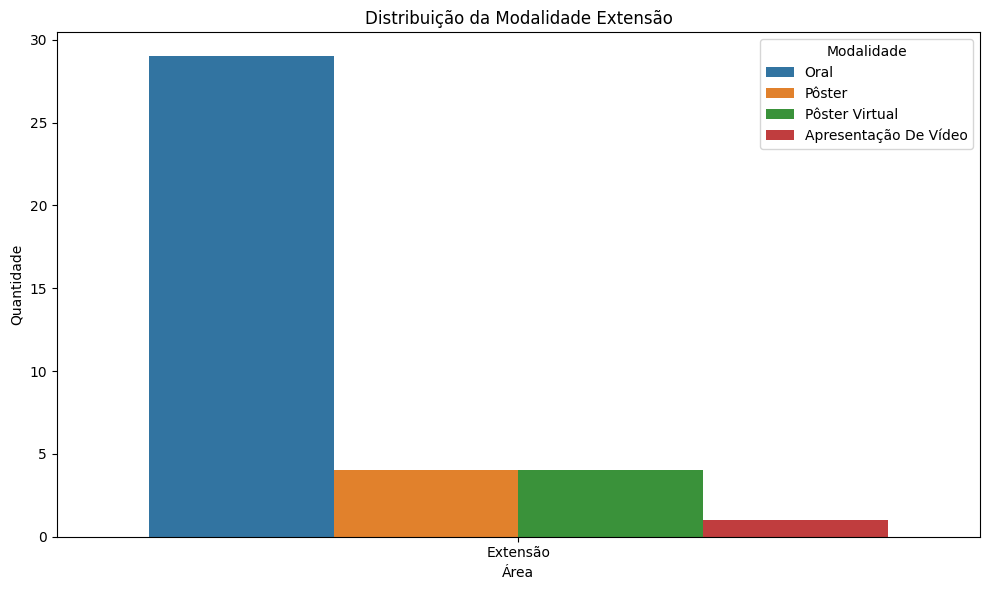

In [ ]:
df_grouped = df_grouped_area_modalidade[df_grouped_area_modalidade['area'] == 'Extensão']

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_grouped,
    x="area",
    y="count",
    hue="modalidade"
)

plt.title("Distribuição da Modalidade Extensão")
plt.xlabel("Área")
plt.ylabel("Quantidade")
plt.legend(title="Modalidade")
plt.tight_layout()
plt.show()

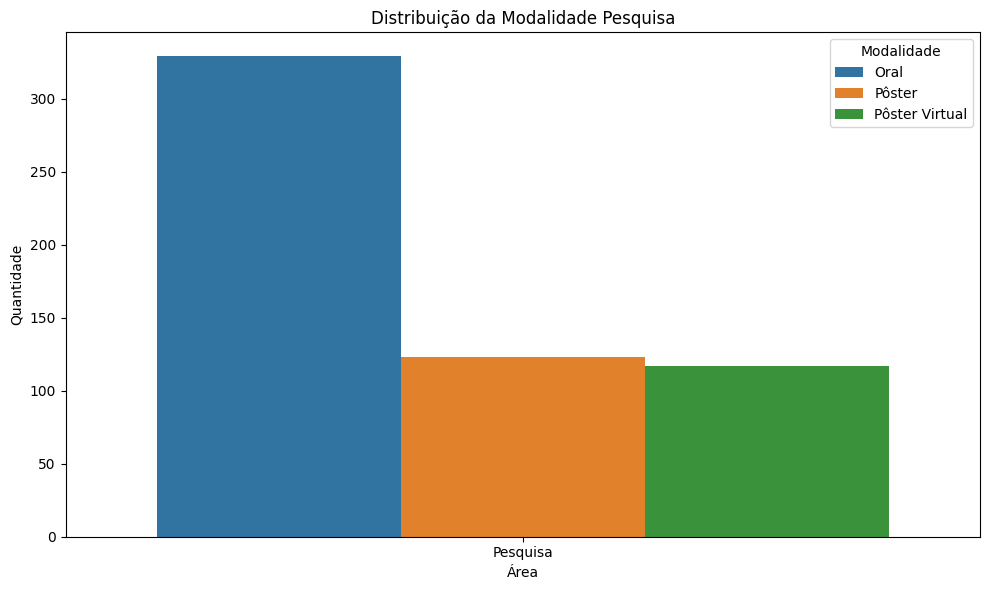

In [ ]:
df_grouped = df_grouped_area_modalidade[df_grouped_area_modalidade['area'] == 'Pesquisa']

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_grouped,
    x="area",
    y="count",
    hue="modalidade"
)

plt.title("Distribuição da Modalidade Pesquisa")
plt.xlabel("Área")
plt.ylabel("Quantidade")
plt.legend(title="Modalidade")
plt.tight_layout()
plt.show()

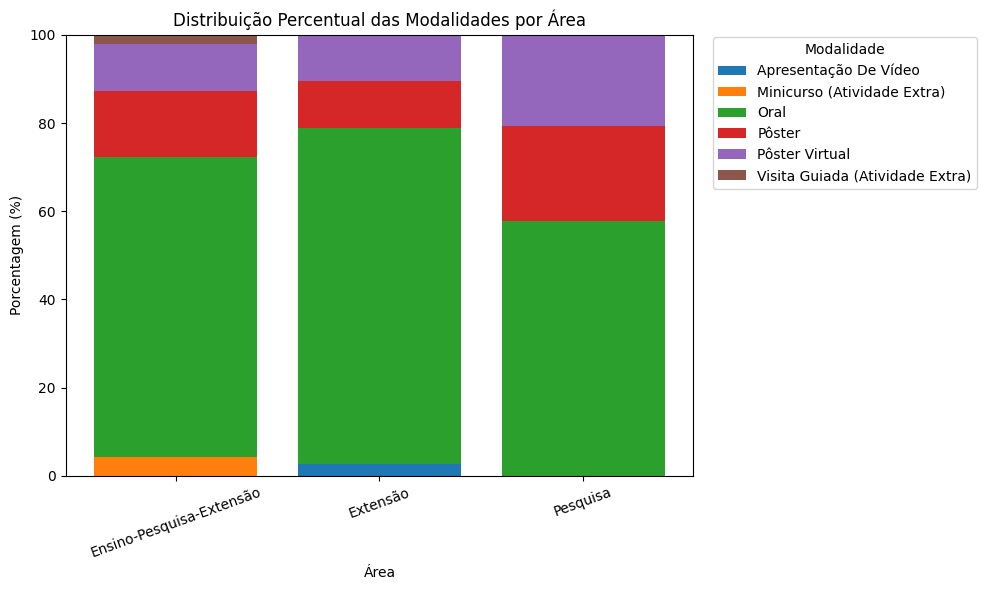

In [ ]:
# --- Pivot para formar matriz área × modalidade ---
df_pivot = df_grouped_area_modalidade.pivot(index="area", columns="modalidade", values="count").fillna(0)

# --- Converter para porcentagem por área ---
df_percent = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

# --- Plotar ---
plt.figure(figsize=(10, 6))

# Obter cores do seaborn
palette = sns.color_palette("tab10", n_colors=df_percent.shape[1])

bottom = None

for i, col in enumerate(df_percent.columns):
    plt.bar(
        df_percent.index,
        df_percent[col],
        bottom=bottom,
        label=col,
        color=palette[i]
    )
    # Atualizar o "bottom" para empilhar
    bottom = df_percent[col] if bottom is None else bottom + df_percent[col]

plt.ylabel("Porcentagem (%)")
plt.xlabel("Área")
plt.title("Distribuição Percentual das Modalidades por Área")
plt.xticks(rotation=20)
plt.legend(title="Modalidade", bbox_to_anchor=(1.02, 1.01), loc='upper left')
plt.tight_layout()
plt.show()

#### Distribuição por Área e Quantidade de Orientadores

In [ ]:
df_grouped_area_orientador = df.groupby('area')['qtd_orientadores'].value_counts().reset_index(name="count")
df_grouped_area_orientador

,area,qtd_orientadores,count
0,Ensino-Pesquisa-Extensão,1,26
1,Ensino-Pesquisa-Extensão,2,12
2,Ensino-Pesquisa-Extensão,3,7
3,Ensino-Pesquisa-Extensão,4,2
4,Extensão,1,28
5,Extensão,3,5
6,Extensão,2,4
7,Extensão,4,1
8,Pesquisa,1,377
9,Pesquisa,2,125


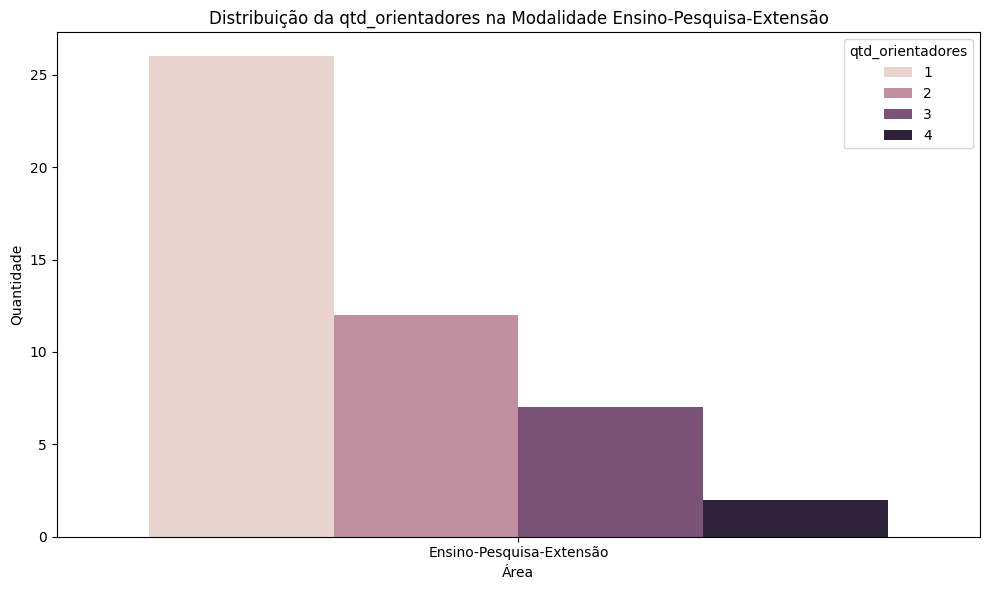

In [ ]:
df_grouped = df_grouped_area_orientador[df_grouped_area_orientador['area'] == 'Ensino-Pesquisa-Extensão']

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_grouped,
    x="area",
    y="count",
    hue="qtd_orientadores"
)

plt.title("Distribuição da qtd_orientadores na Modalidade Ensino-Pesquisa-Extensão")
plt.xlabel("Área")
plt.ylabel("Quantidade")
plt.legend(title="qtd_orientadores")
plt.tight_layout()
plt.show()

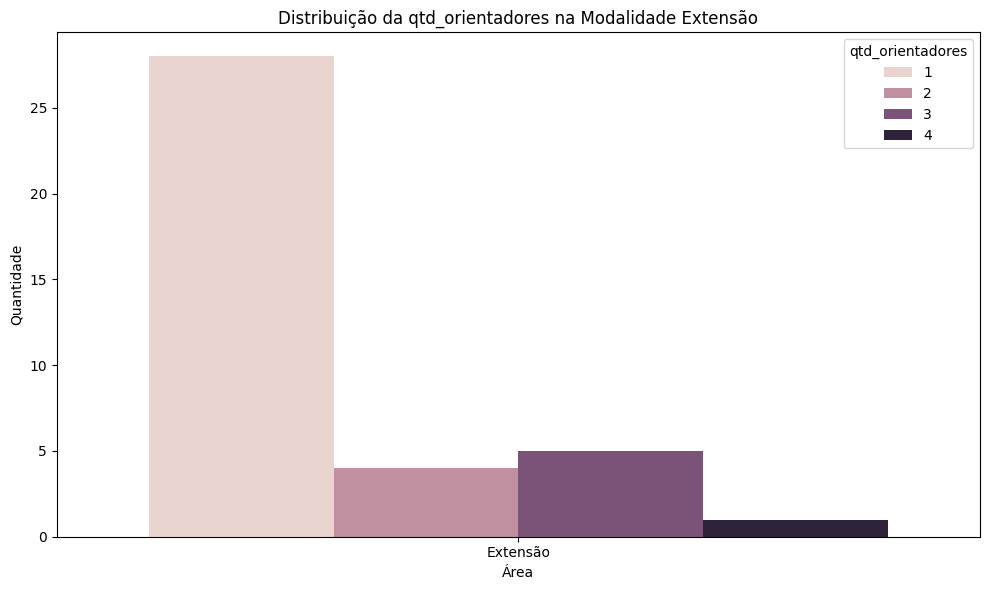

In [ ]:
df_grouped = df_grouped_area_orientador[df_grouped_area_orientador['area'] == 'Extensão']

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_grouped,
    x="area",
    y="count",
    hue="qtd_orientadores"
)

plt.title("Distribuição da qtd_orientadores na Modalidade Extensão")
plt.xlabel("Área")
plt.ylabel("Quantidade")
plt.legend(title="qtd_orientadores")
plt.tight_layout()
plt.show()

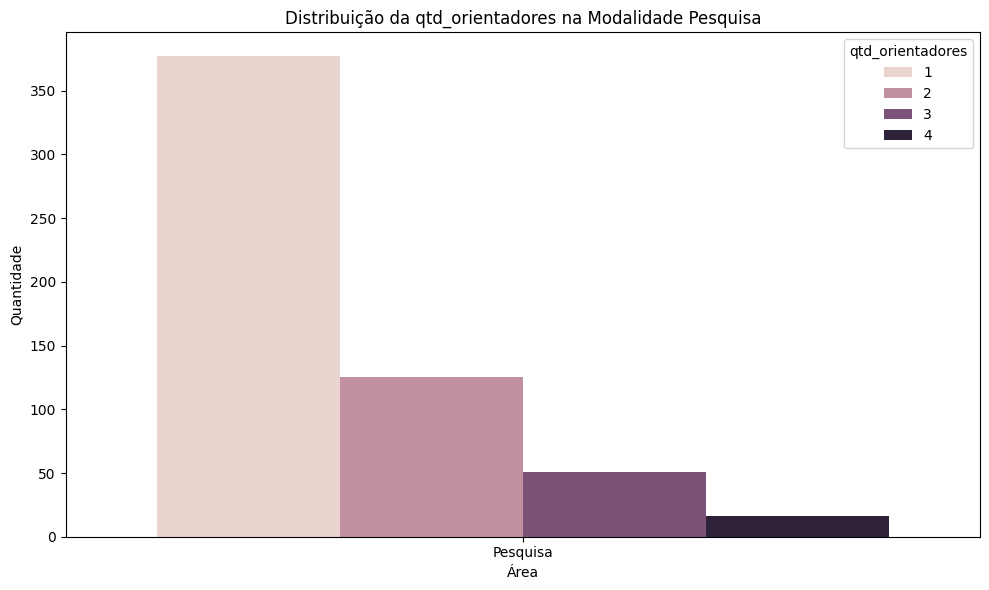

In [ ]:
df_grouped = df_grouped_area_orientador[df_grouped_area_orientador['area'] == 'Pesquisa']

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_grouped,
    x="area",
    y="count",
    hue="qtd_orientadores"
)

plt.title("Distribuição da qtd_orientadores na Modalidade Pesquisa")
plt.xlabel("Área")
plt.ylabel("Quantidade")
plt.legend(title="qtd_orientadores")
plt.tight_layout()
plt.show()

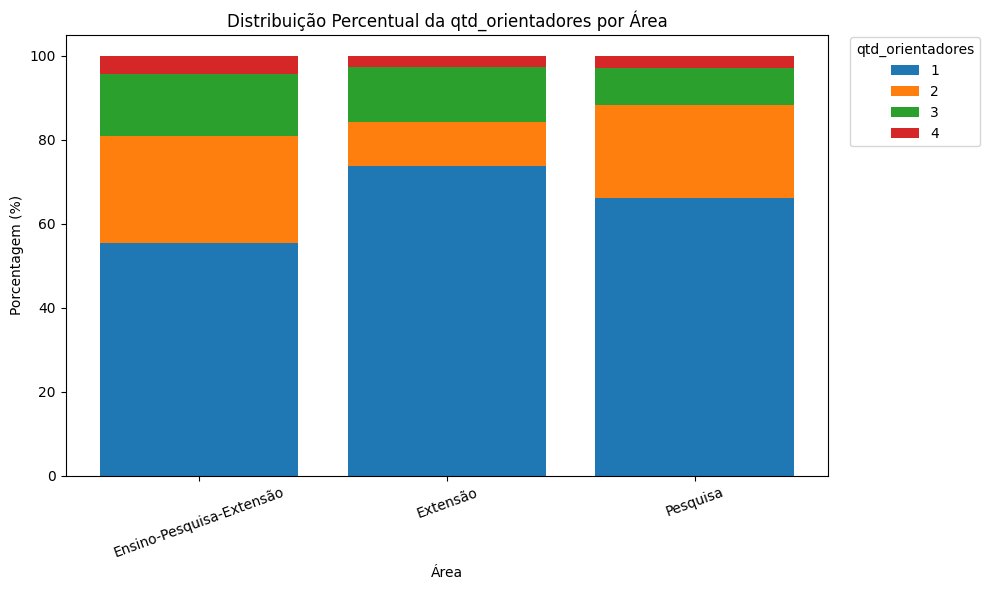

In [ ]:
# --- Pivot para formar matriz área × qtd_orientadores ---
df_pivot = df_grouped_area_orientador.pivot(index="area", columns="qtd_orientadores", values="count").fillna(0)

# --- Converter para porcentagem por área ---
df_percent = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

# --- Plotar ---
plt.figure(figsize=(10, 6))

# Obter cores do seaborn
palette = sns.color_palette("tab10", n_colors=df_percent.shape[1])

bottom = None

for i, col in enumerate(df_percent.columns):
    plt.bar(
        df_percent.index,
        df_percent[col],
        bottom=bottom,
        label=col,
        color=palette[i]
    )
    # Atualizar o "bottom" para empilhar
    bottom = df_percent[col] if bottom is None else bottom + df_percent[col]

plt.ylabel("Porcentagem (%)")
plt.xlabel("Área")
plt.title("Distribuição Percentual da qtd_orientadores por Área")
plt.xticks(rotation=20)
plt.legend(title="qtd_orientadores", bbox_to_anchor=(1.02, 1.01), loc='upper left')
plt.tight_layout()
plt.show()

#### Distribuição por Modalidade e Quantidade de Orientadores

In [ ]:
df_grouped_modalidade_orientador = df.groupby('modalidade')['qtd_orientadores'].value_counts().reset_index(name="count")
df_grouped_modalidade_orientador

,modalidade,qtd_orientadores,count
0,Apresentação De Vídeo,1,1
1,Minicurso (Atividade Extra),1,2
2,Oral,1,252
3,Oral,2,89
4,Oral,3,38
5,Oral,4,11
6,Pôster,1,87
7,Pôster,2,32
8,Pôster,3,11
9,Pôster,4,4


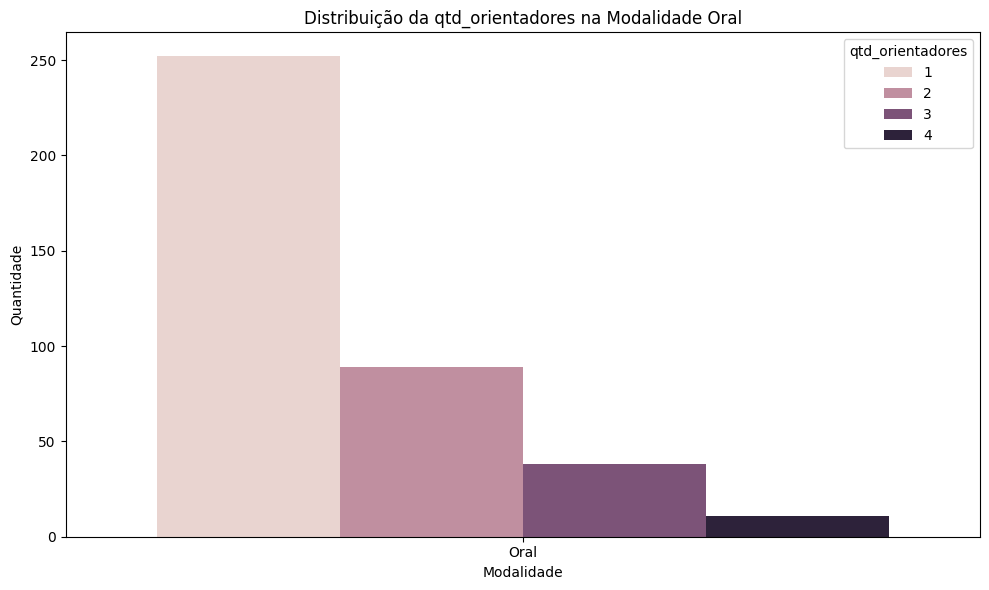

In [ ]:
df_grouped = df_grouped_modalidade_orientador[df_grouped_modalidade_orientador['modalidade'] == 'Oral']

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_grouped,
    x="modalidade",
    y="count",
    hue="qtd_orientadores"
)

plt.title("Distribuição da qtd_orientadores na Modalidade Oral")
plt.xlabel("Modalidade")
plt.ylabel("Quantidade")
plt.legend(title="qtd_orientadores")
plt.tight_layout()
plt.show()

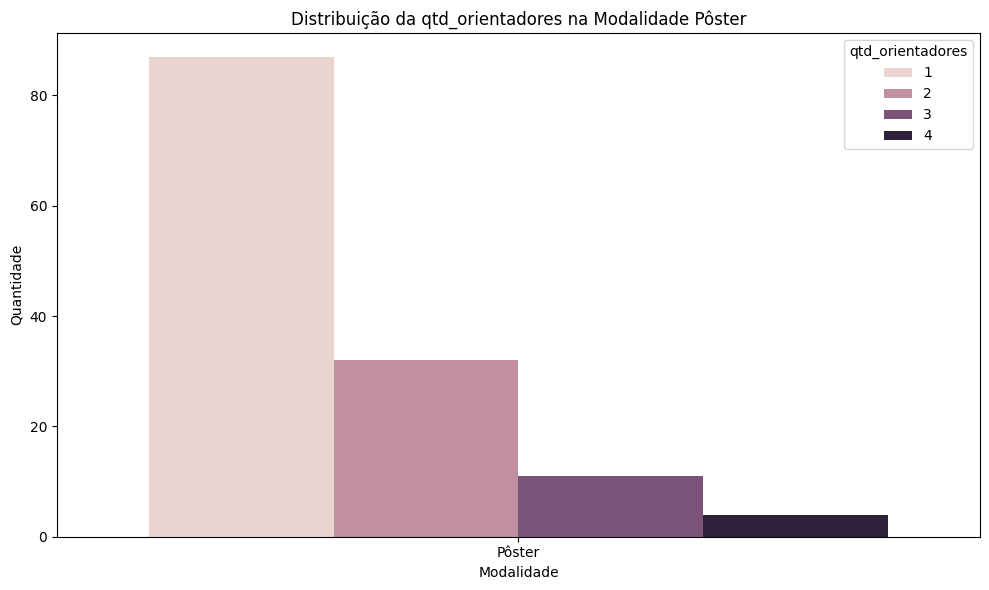

In [ ]:
df_grouped = df_grouped_modalidade_orientador[df_grouped_modalidade_orientador['modalidade'] == 'Pôster']

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_grouped,
    x="modalidade",
    y="count",
    hue="qtd_orientadores"
)

plt.title("Distribuição da qtd_orientadores na Modalidade Pôster")
plt.xlabel("Modalidade")
plt.ylabel("Quantidade")
plt.legend(title="qtd_orientadores")
plt.tight_layout()
plt.show()

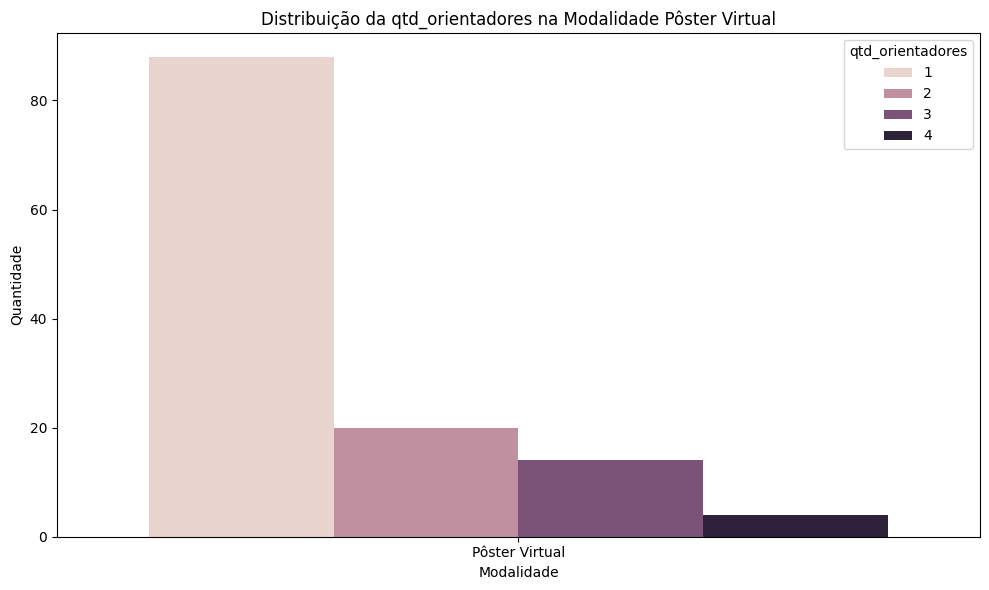

In [ ]:
df_grouped = df_grouped_modalidade_orientador[df_grouped_modalidade_orientador['modalidade'] == 'Pôster Virtual']

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_grouped,
    x="modalidade",
    y="count",
    hue="qtd_orientadores"
)

plt.title("Distribuição da qtd_orientadores na Modalidade Pôster Virtual")
plt.xlabel("Modalidade")
plt.ylabel("Quantidade")
plt.legend(title="qtd_orientadores")
plt.tight_layout()
plt.show()

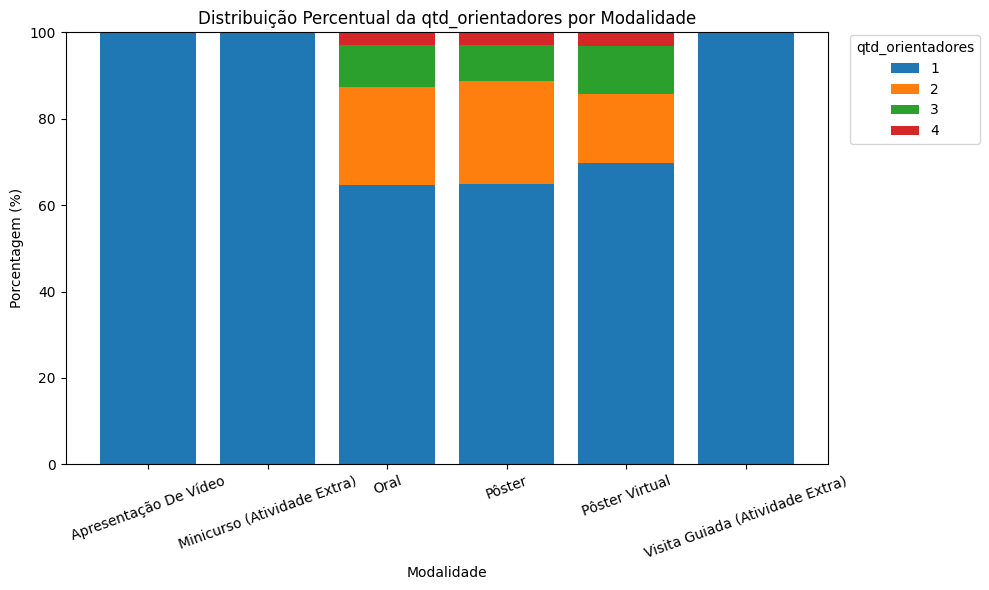

In [ ]:
# --- Pivot para formar matriz modalidade x qtd_orientadores ---
df_pivot = df_grouped_modalidade_orientador.pivot(index="modalidade", columns="qtd_orientadores", values="count").fillna(0)

# --- Converter para porcentagem por qtd_orientadores ---
df_percent = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

# --- Plotar ---
plt.figure(figsize=(10, 6))

# Obter cores do seaborn
palette = sns.color_palette("tab10", n_colors=df_percent.shape[1])

bottom = None

for i, col in enumerate(df_percent.columns):
    plt.bar(
        df_percent.index,
        df_percent[col],
        bottom=bottom,
        label=col,
        color=palette[i]
    )
    # Atualizar o "bottom" para empilhar
    bottom = df_percent[col] if bottom is None else bottom + df_percent[col]

plt.ylabel("Porcentagem (%)")
plt.xlabel("Modalidade")
plt.title("Distribuição Percentual da qtd_orientadores por Modalidade")
plt.xticks(rotation=20)
plt.legend(title="qtd_orientadores", bbox_to_anchor=(1.02, 1.01), loc='upper left')
plt.tight_layout()
plt.show()

# 2) SIAC trabalhos CCMN

In [ ]:
arquivo_entrada = 'siac_ccmn_trabalhos.csv'
print(f"\n[1] Lendo arquivo: {arquivo_entrada}")

try:
  # Tenta ler com utf-8, se falhar tenta latin-1
  df = pd.read_csv(arquivo_entrada, encoding='utf-8')
except UnicodeDecodeError:
  df = pd.read_csv(arquivo_entrada, encoding='latin-1')
except FileNotFoundError:
  print(f"ERRO: O arquivo '{arquivo_entrada}' não foi encontrado. Faça o upload no menu lateral.")
  df = pd.DataFrame()

if not df.empty:
  print(f"    Registros originais carregados: {len(df)}")
  print(f"    Colunas encontradas: {list(df.columns)}")


[1] Lendo arquivo: siac_ccmn_trabalhos.csv
    Registros originais carregados: 757
    Colunas encontradas: ['area', 'modalidade', 'artigo', 'titulo', 'autores', 'orientadores', 'resumo', 'bibliografia']


## Tratamento dos dados

In [ ]:
print("\n[2] Iniciando Tratamento e Limpeza...")

# 2.1 Deduplicação
# Removemos linhas onde o ID do artigo se repete
linhas_iniciais = len(df)
if 'artigo' in df.columns:
    df.drop_duplicates(subset=['artigo'], keep='first', inplace=True)
else:
    # Fallback se não houver coluna artigo: deduplica por título
    df.drop_duplicates(subset=['titulo'], keep='first', inplace=True)

linhas_finais = len(df)
print(f"    Registros duplicados removidos: {linhas_iniciais - linhas_finais}")

# 2.2 Tratamento de Valores Ausentes (Null/NaN)
colunas_texto = ['titulo', 'autores', 'orientadores', 'resumo', 'bibliografia']
for col in colunas_texto:
    if col in df.columns:
        nulos = df[col].isnull().sum()
        if nulos > 0:
            print(f"    Preenchendo {nulos} valores vazios na coluna '{col}'")
            df[col] = df[col].fillna("Não Informado")

# 2.3 Padronização de Strings (Normalização)
colunas_categoricas = ['area', 'modalidade']
for col in colunas_categoricas:
    if col in df.columns:
        # Converte para string, remove espaços e padroniza Capitalização
        df[col] = df[col].astype(str).str.strip().str.title()

# 2.4 Enriquecimento de Dados
# Contar tamanho do resumo
if 'resumo' in df.columns:
    df['tamanho_resumo'] = df['resumo'].apply(lambda x: len(str(x)))

# Estimar número de orientadores e autores
def contar_pessoas(texto):
    if str(texto) == "Não Informado" or str(texto) == "" or pd.isna(texto):
        return 0
    # Conta vírgulas e adiciona 1. Ex: "João, Maria" = 1 vírgula = 2 pessoas
    return str(texto).count(',') + 1

if 'orientadores' in df.columns:
    df['qtd_orientadores'] = df['orientadores'].apply(contar_pessoas)

# Vamos contar autores também para enriquecer a análise do CCMN
if 'autores' in df.columns:
    df['qtd_autores'] = df['autores'].apply(contar_pessoas)



[2] Iniciando Tratamento e Limpeza...
    Registros duplicados removidos: 0
    Preenchendo 757 valores vazios na coluna 'autores'


## Análise exploratória

In [ ]:
print("\n[3] Gerando Estatísticas e Gráficos...")

# 3.1 Estatísticas Descritivas
colunas_stats = [c for c in ['tamanho_resumo', 'qtd_orientadores', 'qtd_autores'] if c in df.columns]
stats_desc = df[colunas_stats].describe()
print("\n--- Estatísticas Descritivas (CCMN) ---")
print(stats_desc)


[3] Gerando Estatísticas e Gráficos...

--- Estatísticas Descritivas (CCMN) ---
       tamanho_resumo  qtd_orientadores  qtd_autores
count      757.000000        757.000000        757.0
mean      2461.627477          1.401585          0.0
std        525.722351          0.734557          0.0
min        800.000000          1.000000          0.0
25%       2107.000000          1.000000          0.0
50%       2625.000000          1.000000          0.0
75%       2922.000000          2.000000          0.0
max       3098.000000          5.000000          0.0


Gráficos

/tmp/ipython-input-1212870419.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='modalidade', data=df, order=contagem.index, palette='viridis')


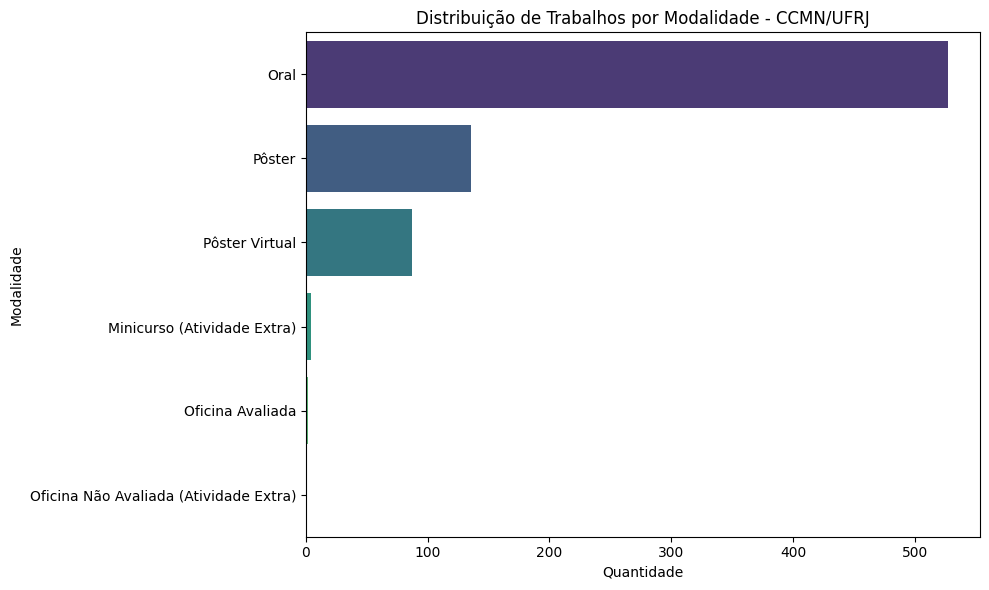

<Figure size 640x480 with 0 Axes>

In [ ]:
# Gráfico 1: Modalidade
plt.figure(figsize=(10, 6))
if 'modalidade' in df.columns:
    contagem = df['modalidade'].value_counts()
    sns.countplot(y='modalidade', data=df, order=contagem.index, palette='viridis')
    plt.title('Distribuição de Trabalhos por Modalidade - CCMN/UFRJ')
    plt.xlabel('Quantidade')
    plt.ylabel('Modalidade')
    plt.tight_layout()
    plt.show()
    plt.savefig('ccmn_grafico_modalidades.png')

/tmp/ipython-input-2480252542.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contagem_area.values, y=contagem_area.index, palette='magma')


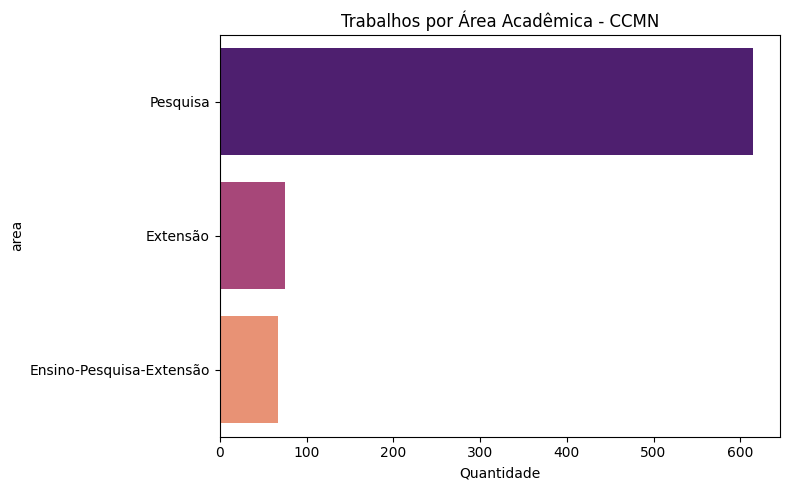

<Figure size 640x480 with 0 Axes>

In [ ]:
# Gráfico 2: Área
plt.figure(figsize=(8, 5))
if 'area' in df.columns:
    contagem_area = df['area'].value_counts()
    sns.barplot(x=contagem_area.values, y=contagem_area.index, palette='magma')
    plt.title('Trabalhos por Área Acadêmica - CCMN')
    plt.xlabel('Quantidade')
    plt.tight_layout()
    plt.show()
    plt.savefig('ccmn_grafico_areas.png')

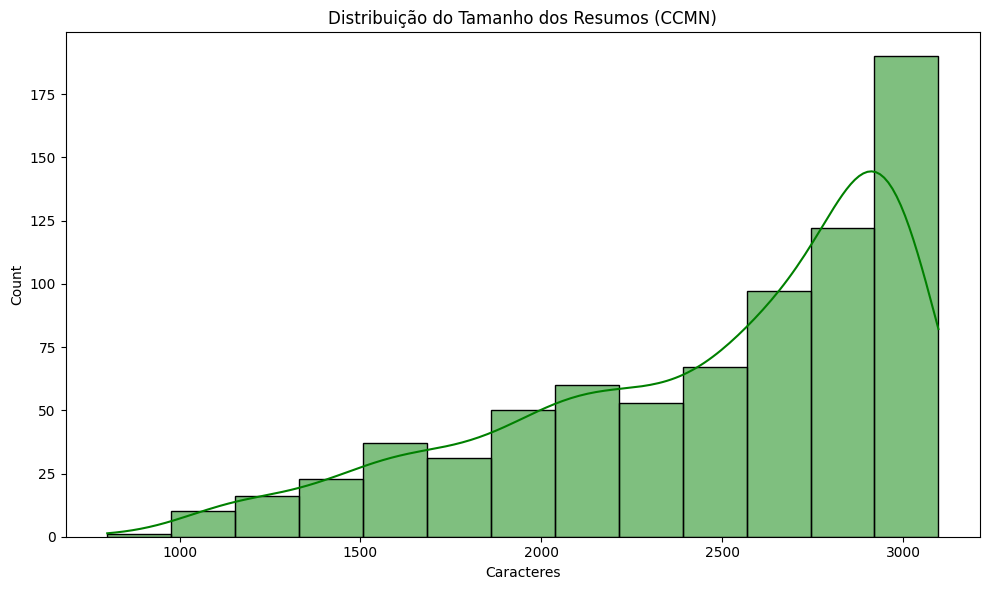

<Figure size 640x480 with 0 Axes>

In [ ]:
# Gráfico 3: Histograma Resumos
plt.figure(figsize=(10, 6))
if 'tamanho_resumo' in df.columns:
    sns.histplot(df['tamanho_resumo'], kde=True, color='green')
    plt.title('Distribuição do Tamanho dos Resumos (CCMN)')
    plt.xlabel('Caracteres')
    plt.tight_layout()
    plt.show()
    plt.savefig('ccmn_histograma_resumos.png')

In [ ]:

# 3.3 Identificação de Outliers (Resumos)
if 'tamanho_resumo' in df.columns:
    Q1 = df['tamanho_resumo'].quantile(0.25)
    Q3 = df['tamanho_resumo'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df['tamanho_resumo'] < (Q1 - 1.5 * IQR)) | (df['tamanho_resumo'] > (Q3 + 1.5 * IQR))]
    print(f"\n    Outliers de tamanho de resumo detectados: {len(outliers)}")


    Outliers de tamanho de resumo detectados: 1


## Salvamento

In [ ]:
print("\n[4] Salvando Base Tratada...")

# Define colunas finais desejadas (Tidy Data)
colunas_finais = [
'artigo', 'area', 'modalidade', 'titulo',
'autores', 'qtd_autores',
'orientadores', 'qtd_orientadores',
'resumo', 'tamanho_resumo'
]

# Filtra apenas as que existem no dataframe atual
cols_existentes = [c for c in colunas_finais if c in df.columns]
df_final = df[cols_existentes]

nome_saida = 'SIAC_CCMN_Tratado.csv'
df_final.to_csv(nome_saida, index=False, encoding='utf-8-sig')
print(f"    Arquivo final gerado: {nome_saida}")
print("    (Verifique a aba de arquivos à esquerda para baixar os resultados)")



[4] Salvando Base Tratada...
    Arquivo final gerado: SIAC_CCMN_Tratado.csv
    (Verifique a aba de arquivos à esquerda para baixar os resultados)


# 3) SIAC trabalhos CLA

Extraindo CSV

In [ ]:
arquivo_entrada = 'siac_cla_trabalhos.csv'
print(f"\n[1] Lendo arquivo: {arquivo_entrada}")

try:
    # Tenta ler com utf-8, se falhar tenta latin-1
    df = pd.read_csv(arquivo_entrada, encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(arquivo_entrada, encoding='latin-1')
except FileNotFoundError:
    print(f"ERRO: O arquivo '{arquivo_entrada}' não foi encontrado. Faça o upload no menu lateral.")
    df = pd.DataFrame()

if not df.empty:
    print(f"    Registros originais carregados: {len(df)}")
    print(f"    Colunas encontradas: {list(df.columns)}")


[1] Lendo arquivo: siac_cla_trabalhos.csv
    Registros originais carregados: 813
    Colunas encontradas: ['area', 'modalidade', 'artigo', 'titulo', 'autores', 'orientadores', 'resumo', 'bibliografia']


## Tranformação de dados

In [ ]:
print("\n[2] Iniciando Tratamento e Limpeza...")

# 2.1 Deduplicação
linhas_iniciais = len(df)
if 'artigo' in df.columns:
    df.drop_duplicates(subset=['artigo'], keep='first', inplace=True)
else:
    df.drop_duplicates(subset=['titulo'], keep='first', inplace=True)

linhas_finais = len(df)
print(f"    Registros duplicados removidos: {linhas_iniciais - linhas_finais}")

# 2.2 Tratamento de Valores Ausentes (Null/NaN)
colunas_texto = ['titulo', 'autores', 'orientadores', 'resumo', 'bibliografia']
for col in colunas_texto:
    if col in df.columns:
        nulos = df[col].isnull().sum()
        if nulos > 0:
            print(f"    Preenchendo {nulos} valores vazios na coluna '{col}'")
            df[col] = df[col].fillna("Não Informado")

# 2.3 Padronização de Strings (Normalização)
colunas_categoricas = ['area', 'modalidade']
for col in colunas_categoricas:
    if col in df.columns:
        # Converte para string, remove espaços e padroniza Capitalização
        df[col] = df[col].astype(str).str.strip().str.title()

# 2.4 Enriquecimento de Dados
# Contar tamanho do resumo
if 'resumo' in df.columns:
    df['tamanho_resumo'] = df['resumo'].apply(lambda x: len(str(x)))

# Estimar número de orientadores e autores
def contar_pessoas(texto):
    if str(texto) == "Não Informado" or str(texto) == "" or pd.isna(texto):
        return 0
    return str(texto).count(',') + 1

if 'orientadores' in df.columns:
    df['qtd_orientadores'] = df['orientadores'].apply(contar_pessoas)

if 'autores' in df.columns:
    df['qtd_autores'] = df['autores'].apply(contar_pessoas)



[2] Iniciando Tratamento e Limpeza...
    Registros duplicados removidos: 0
    Preenchendo 813 valores vazios na coluna 'autores'


## Análise Exploratória

In [ ]:
print("\n[3] Gerando Estatísticas e Gráficos...")

# 3.1 Estatísticas Descritivas
colunas_stats = [c for c in ['tamanho_resumo', 'qtd_orientadores', 'qtd_autores'] if c in df.columns]
stats_desc = df[colunas_stats].describe()
print("\n--- Estatísticas Descritivas (CLA) ---")
print(stats_desc)


[3] Gerando Estatísticas e Gráficos...

--- Estatísticas Descritivas (CLA) ---
       tamanho_resumo  qtd_orientadores  qtd_autores
count      813.000000        813.000000        813.0
mean      2350.938499          1.166052          0.0
std        562.865858          0.506829          0.0
min       1006.000000          1.000000          0.0
25%       1960.000000          1.000000          0.0
50%       2451.000000          1.000000          0.0
75%       2872.000000          1.000000          0.0
max       3098.000000          4.000000          0.0


/tmp/ipython-input-366794718.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='modalidade', data=df, order=contagem.index, palette='flare') # Palette diferente para o CLA


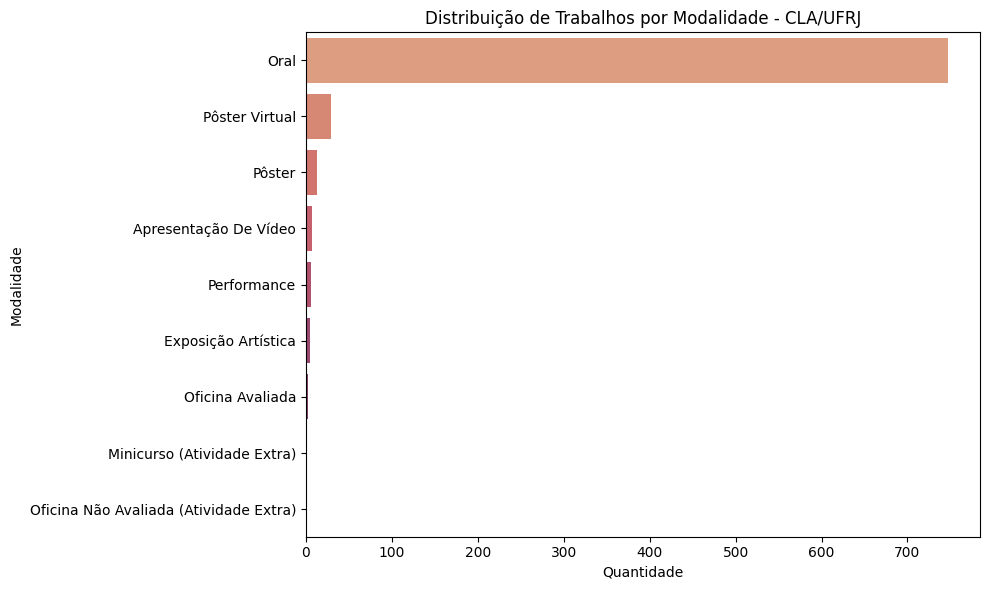

<Figure size 640x480 with 0 Axes>

In [ ]:
# Gráfico 1: Modalidade (Observar se aparecem 'Performance', 'Concerto' etc)
plt.figure(figsize=(10, 6))
if 'modalidade' in df.columns:
  contagem = df['modalidade'].value_counts()
  sns.countplot(y='modalidade', data=df, order=contagem.index, palette='flare') # Palette diferente para o CLA
  plt.title('Distribuição de Trabalhos por Modalidade - CLA/UFRJ')
  plt.xlabel('Quantidade')
  plt.ylabel('Modalidade')
  plt.tight_layout()
  plt.show()
  plt.savefig('cla_grafico_modalidades.png')


/tmp/ipython-input-2988542972.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contagem_area.values, y=contagem_area.index, palette='crest')


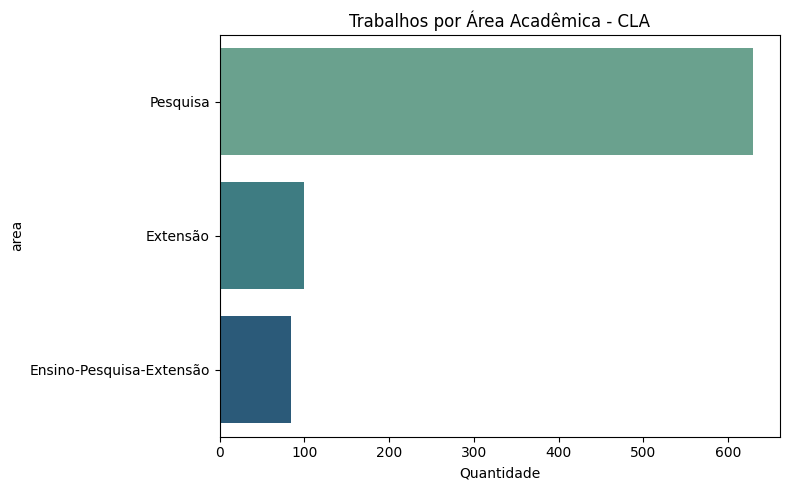

<Figure size 640x480 with 0 Axes>

In [ ]:
# Gráfico 2: Área
plt.figure(figsize=(8, 5))
if 'area' in df.columns:
  contagem_area = df['area'].value_counts()
  sns.barplot(x=contagem_area.values, y=contagem_area.index, palette='crest')
  plt.title('Trabalhos por Área Acadêmica - CLA')
  plt.xlabel('Quantidade')
  plt.tight_layout()
  plt.show()
  plt.savefig('cla_grafico_areas.png')

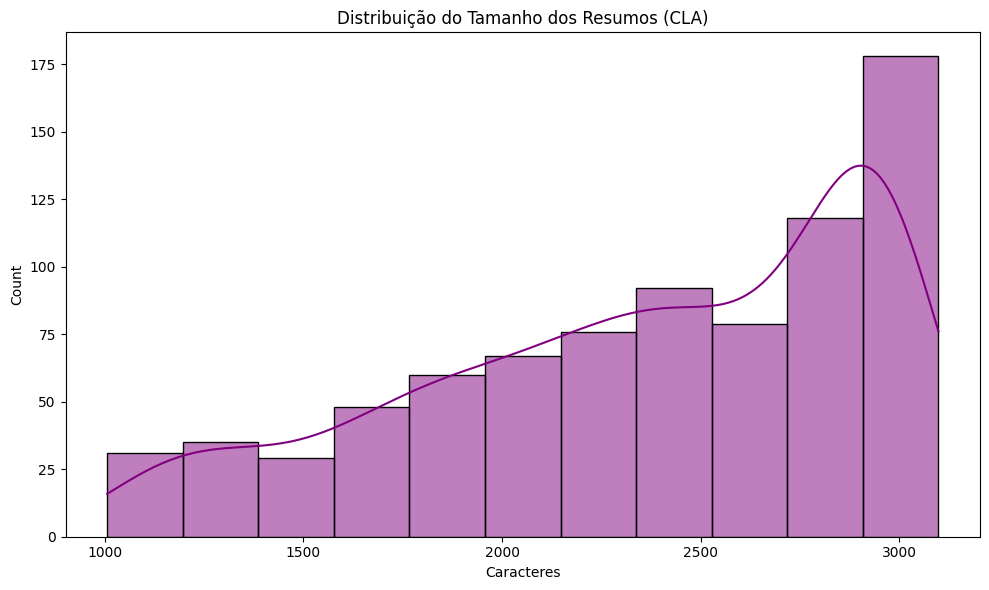

<Figure size 640x480 with 0 Axes>

In [ ]:
# Gráfico 3: Histograma Resumos
plt.figure(figsize=(10, 6))
if 'tamanho_resumo' in df.columns:
  sns.histplot(df['tamanho_resumo'], kde=True, color='purple') # Cor roxa para Artes/Letras
  plt.title('Distribuição do Tamanho dos Resumos (CLA)')
  plt.xlabel('Caracteres')
  plt.tight_layout()
  plt.show()
  plt.savefig('cla_histograma_resumos.png')

In [ ]:
# 3.3 Identificação de Outliers
if 'tamanho_resumo' in df.columns:
  Q1 = df['tamanho_resumo'].quantile(0.25)
  Q3 = df['tamanho_resumo'].quantile(0.75)
  IQR = Q3 - Q1
  outliers = df[(df['tamanho_resumo'] < (Q1 - 1.5 * IQR)) | (df['tamanho_resumo'] > (Q3 + 1.5 * IQR))]
  print(f"\n    Outliers de tamanho de resumo detectados: {len(outliers)}")


    Outliers de tamanho de resumo detectados: 0


## Salvamento

In [ ]:
print("\n[4] Salvando Base Tratada...")

# Colunas finais (Tidy Data)
colunas_finais = [
    'artigo', 'area', 'modalidade', 'titulo',
    'autores', 'qtd_autores',
    'orientadores', 'qtd_orientadores',
    'resumo', 'tamanho_resumo'
]

cols_existentes = [c for c in colunas_finais if c in df.columns]
df_final = df[cols_existentes]

nome_saida = 'SIAC_CLA_Tratado.csv'
df_final.to_csv(nome_saida, index=False, encoding='utf-8-sig')
print(f"    Arquivo final gerado: {nome_saida}")
print("    (Verifique a aba de arquivos à esquerda para baixar os resultados)")


[4] Salvando Base Tratada...
    Arquivo final gerado: SIAC_CLA_Tratado.csv
    (Verifique a aba de arquivos à esquerda para baixar os resultados)



--- Processando CLA ---
Média calculada: 3.23

--- Processando CT ---
Média calculada: 3.15

--- Processando CCMN ---
Média calculada: 3.15


/tmp/ipython-input-3644894325.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Centro', y='qtd_equipe', data=df_plot, palette='viridis', showfliers=False)



Gráfico salvo como 'comparacao_autores_final.png'


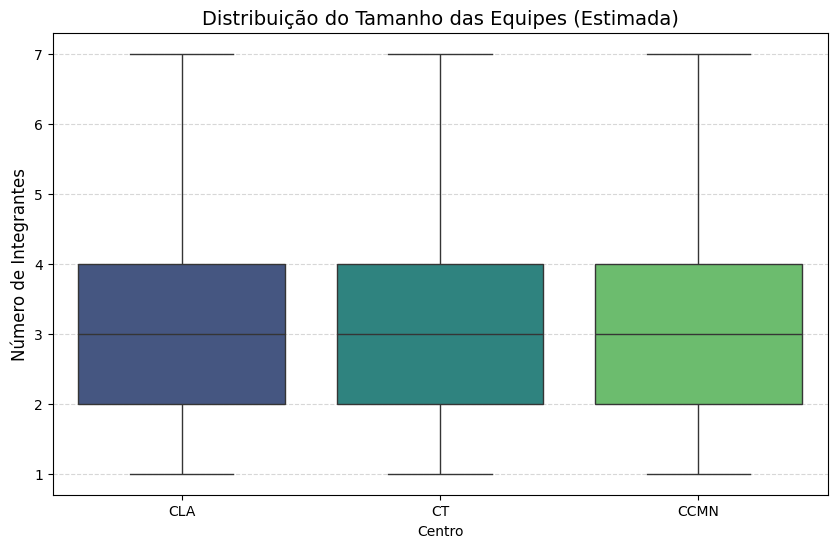

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. LEITURA FORÇADA COM PONTO E VÍRGULA ---
# Bases da SIAc costumam usar ';' como separador e 'latin-1'
def ler_na_marra(arquivo):
    try:
        # Forçamos sep=';' pois sep=None pode estar falhando
        return pd.read_csv(arquivo, sep=';', encoding='latin-1', on_bad_lines='skip')
    except:
        # Fallback para vírgula
        return pd.read_csv(arquivo, sep=',', encoding='latin-1', on_bad_lines='skip')

df_cla = ler_na_marra('siac_cla_trabalhos.csv')
df_ct = ler_na_marra('SIAC_trabalhos_CT.csv')
df_ccmn = ler_na_marra('siac_ccmn_trabalhos.csv')

dfs = {'CLA': df_cla, 'CT': df_ct, 'CCMN': df_ccmn}
dfs_finais = []

# --- 2. LÓGICA DE CONTAGEM HÍBRIDA ---
def calcular_tamanho_equipe(row):
    # Estratégia A: Tenta contar pela coluna 'autores' se ela existir e tiver dados
    col_autores = None
    for c in row.index:
        if 'autores' in c.lower() or 'integrantes' in c.lower():
            col_autores = c
            break

    if col_autores and pd.notna(row[col_autores]):
        texto = str(row[col_autores])
        # Conta vírgulas ou ponto-e-vírgulas
        n_sep = texto.count(',') + texto.count(';')
        if n_sep > 0:
            return n_sep + 1
        return 1 # Se tem texto mas sem separador, assumimos 1 autor

    # Estratégia B: Se 'autores' falhar, conta colunas preenchidas de Aluno/Orientador
    # (Muitas bases separam: Aluno 1, Aluno 2, Orientador 1...)
    contador = 0
    keywords = ['aluno', 'orientador', 'autor', 'coautor']
    for col in row.index:
        if any(k in col.lower() for k in keywords) and pd.notna(row[col]):
            contador += 1

    return contador if contador > 0 else 1 # Mínimo 1

# --- 3. PROCESSAMENTO ---
for nome, df in dfs.items():
    print(f"\n--- Processando {nome} ---")
    if df.empty:
        print("Arquivo vazio ou não lido.")
        continue

    # Aplica a função linha a linha
    df['qtd_equipe'] = df.apply(calcular_tamanho_equipe, axis=1)
    df['Centro'] = nome

    # Remove casos bizarros (0 ou > 20)
    df = df[(df['qtd_equipe'] > 0) & (df['qtd_equipe'] < 20)]

    dfs_finais.append(df[['Centro', 'qtd_equipe']])

    # Debug: ver se a média faz sentido agora
    print(f"Média calculada: {df['qtd_equipe'].mean():.2f}")

# --- 4. PLOTAGEM ---
if dfs_finais:
    df_plot = pd.concat(dfs_finais)

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Centro', y='qtd_equipe', data=df_plot, palette='viridis', showfliers=False)

    plt.title('Distribuição do Tamanho das Equipes (Estimada)', fontsize=14)
    plt.ylabel('Número de Integrantes', fontsize=12)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)

    # Forçar inteiros no eixo Y
    from matplotlib.ticker import MaxNLocator
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.savefig('comparacao_autores_final.png', dpi=300, bbox_inches='tight')
    print("\nGráfico salvo como 'comparacao_autores_final.png'")
    plt.show()
else:
    print("Não foi possível extrair dados de nenhum arquivo.")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import unicodedata

# ... (Mantenha as funções de leitura anteriores) ...

# LISTA DE REMOÇÃO CIRÚRGICA (Baseada nas suas imagens)
faxina_pesada = set([
    # Erros de encoding visíveis
    'tambam', 'alam', 'atravas', 'formaaao', 'percnt', 'dessa', 'desse',
    'deste', 'neste', 'nesse', 'sendo', 'assim', 'entao', 'porem', 'tanta',
    'quanto', 'cada', 'qual', 'pode', 'devido', 'alem', 'atraves', 'tambem',
    'formacao', 'soluaao', 'solucao', 'utilizado', 'utilizada', 'realizada',
    'realizado', 'obtur', 'obtido', 'analises', 'possivel', 'relacao', 'relaaao',
    'condiaaes', 'condicoes', 'avaliar', 'avaliaaao', 'aplicaaao', 'aplicacao',
    'produaao', 'producao', 'caracteristica', 'caracterizaaao'
])

# Juntar com as stopwords básicas (do código anterior)
# Se não tiver a lista anterior, use apenas esta faxina_pesada para testar
todas_stopwords = faxina_pesada.union({
    'de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'com', 'nao', 'uma',
    'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele',
    'das', 'tem', 'foi', 'pelo', 'nos', 'essa', 'esse', 'esta', 'este', 'sao', 'ser'
})

def limpar_texto_final(texto):
    if pd.isna(texto): return ""
    # Remove acentos
    texto = unicodedata.normalize('NFKD', str(texto)).encode('ASCII', 'ignore').decode('ASCII')
    texto = texto.lower()
    # Remove tudo que não é letra
    texto = re.sub(r'[^a-z\s]', '', texto)
    return texto

for nome_centro, df in dfs.items():
    if df.empty: continue

    print(f"Gerando nuvem limpa para: {nome_centro}...")

    # Coleta texto
    cols_texto = [c for c in df.columns if 'titulo' in c.lower() or 'resumo' in c.lower()]
    texto_acumulado = []

    for col in cols_texto:
        palavras_coluna = df[col].apply(limpar_texto_final).str.split()
        for lista in palavras_coluna:
            if isinstance(lista, list):
                # Filtra stopwords E palavras pequenas (<4 letras)
                filtradas = [p for p in lista if p not in todas_stopwords and len(p) > 3]
                texto_acumulado.extend(filtradas)

    if not texto_acumulado: continue

    # Gera WordCloud
    wc = WordCloud(width=1200, height=600, background_color='white',
                   max_words=60, colormap='tab10', stopwords=todas_stopwords).generate(" ".join(texto_acumulado))

    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    # Título removido da imagem para ficar mais limpo no relatório (usa o caption do LaTeX)
    plt.savefig(f'wordcloud_{nome_centro}_final.png', bbox_inches='tight', dpi=300)
    plt.close()
    print(f"Salvo: wordcloud_{nome_centro}_final.png")

Gerando nuvem limpa para: CLA...
Salvo: wordcloud_CLA_final.png
Gerando nuvem limpa para: CT...
Salvo: wordcloud_CT_final.png
Gerando nuvem limpa para: CCMN...
Salvo: wordcloud_CCMN_final.png
